# Imports

In [19]:
# Imports

# Webscraping Imports
import requests
from bs4 import BeautifulSoup
import random
import pandas as pd
import matplotlib.pyplot as plt

# ML library imports
import nltk
from nltk.tokenize import word_tokenize
from nltk import ngrams
import nltk.collocations
from nltk import BigramCollocationFinder
from nltk.probability import FreqDist

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Formatting
from pprint import pprint
import datetime

In [20]:
#todays date
date = datetime.date.today()

In [21]:
print(date)

2025-05-11


# Defining Functions

In [2]:
## Webscraping functions

In [23]:
# Variables
page_limit = 200
page_num = 1
request_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Data%2BScientist&location=San%2BFrancisco%2BBay%2BArea&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&start={page_num}"

In [24]:
def scrape_jobs(request_url, page_limit):
    job_list = []
    for page_num in range(1,page_limit):
        list_url = request_url 
        # Getting response request from list 
        response = requests.get(list_url)
    
        list_data = response.text
        list_soup = BeautifulSoup(list_data, 'html.parser')
        page_jobs = list_soup.find_all("li")
        #10 jobs per page
        #print(len(page_jobs))
        
        ## Get job ID's from each page
        id_list = []
    
        for job in page_jobs:
            base_card_div = job.find("div", {"class": "base-card"})
            job_id = base_card_div.get("data-entity-urn").split(":")[3]
            id_list.append(job_id)
            
        # For every job with ID, get the information
        for job_id in id_list:
            job_url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"
            job_response = requests.get(job_url)
            if(job_response.status_code == 200):
                #print(job_response.status_code)
                job_soup = BeautifulSoup(job_response.text, "html.parser")
                job_post = {}
                try:
                    job_post["days_ago_posted"] = job_soup.find( "span", {"class": "posted-time-ago__text topcard__flavor--metadata"}).text.strip()
                except:
                    job_post["days_ago_posted"] = None
                # if(job_post["days_ago_posted"] != None and ("days" in job_post["days_ago_posted"] or "hours" in job_post["days_ago_posted"])): 
                try:
                    job_post["company_name"] = job_soup.find( "a", {"class": "topcard__org-name-link topcard__flavor--black-link"}).text.strip()
                except: 
                    job_post["company_name"] = None
                try:
                    job_post["job_title"] = job_soup.find( "h2", {"class": "top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title"}).text.strip()
                except: 
                    job_post["job_title"] = None
                try:
                    job_post["job_description"] = job_soup.find( "div", {"class":"show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden" }).text.strip()
                except: 
                    job_post["job_description"] = None
                try:
                    job_post["num_applicants"] = job_soup.find( "figcaption", {"class": "num-applicants__caption"}).text.strip()
                except:
                    job_post["num_applicants"] = None
                job_list.append(job_post)
    return pd.DataFrame(job_list)
        

In [25]:
jobs_df = scrape_jobs(request_url, 2)

In [26]:
jobs_df

,days_ago_posted,company_name,job_title,job_description,num_applicants
0,2 weeks ago,Notion,"Data Scientist, GTM",About UsWe're on a mission to make it possible...,None
1,6 days ago,Discord,"Data Scientist, Analytics",Discord is used by over 200 million people eve...,Over 200 applicants
2,6 days ago,Handshake,"Data Scientist, Consumer Research & Marketing",Everyone is welcome at Handshake. We know dive...,Over 200 applicants
3,5 days ago,Meta,"Data Scientist, Product Analytics","As a Data Scientist at Meta, you will shape th...",None
4,6 days ago,Notion,"Data Scientist, Finance",About UsWe're on a mission to make it possible...,Over 200 applicants
5,5 days ago,Meta,"Data Scientist, Product Analytics","As a Data Scientist at Meta, you will shape th...",None
6,5 days ago,Meta,"Data Scientist, Product Analytics","As a Data Scientist at Meta, you will shape th...",None
7,5 days ago,Meta,"Data Scientist, Product Analytics","As a Data Scientist at Meta, you will shape th...",None
8,3 weeks ago,Pinterest,Data Scientist I,About PinterestMillions of people around the w...,None
9,5 days ago,Meta,"Data Scientist, Product Analytics","As a Data Scientist at Meta, you will shape th...",Over 200 applicants


In [61]:
def categorical_variables(df):
    df['days_ago_posted'].value_counts().plot(kind='pie')
    plt.title('Date of Posting Distribution')
    plt.show()
    
    df['job_title'].value_counts().plot(kind='pie')
    plt.title('Title Distribution')
    plt.show()

    data_analyst_jobs_df['company_name'].value_counts().plot(kind='pie')
    plt.title('Company Distribution')
    plt.show()
    
    data_analyst_jobs_df['num_applicants'].value_counts().plot(kind='pie')
    plt.title('Number of Applicants Distribution')
    plt.show()

## ML Functions

In [27]:
def create_stop_words():
    stop_words = set(stopwords.words("english"))
    stop_words.add(':')
    stop_words.add(',')
    stop_words.add('.')
    stop_words.add(', ')
    stop_words.add('. ')
    stop_words.add('*')
    stop_words.add("'")
    stop_words.add("'s")
    stop_words.add('e.g')
    stop_words.add('employees')
    stop_words.add('applicants')
    stop_words.add(')')
    stop_words.add('(')
    stop_words.add('eligible')
    stop_words.add('participate')
    stop_words.update(['contract','salary', 'range', 'sunnyvale', 'candidates', 'recruiting', 'hiring', 'fair', 'chance'])
    return(stop_words)

In [28]:
stop_words = create_stop_words()

In [29]:
def get_n_grams(word_list, n, top_n):
    '''
        Function to return ngrams
        word_list: pass lowercase word list (filtered for stop words)
        n: the number of words in each phrase (gram)
        top_n: top n number of matches 
    '''
    grams = list(ngrams(word_list, n))
    freq_dist = FreqDist(grams)
    
    topn = freq_dist.most_common(top_n)
    return(topn)

In [30]:
def return_n_grams():
    bigram_list = []
    # trigram_list = []
    
    #Create a dictionary of the most common bigrams
    bigram_dict = {}
    # trigram_dict = {}
    
    #for every job in job_list dataframe
    for i in range(len(jobs_df)): # change to len(jobs_df)
        # print(jobs_df['job_description'][i], '\n')
        # Grab the job description
        text = jobs_df['job_description'][i]
    
        #Tokenize and filter unnecessary words, and put relevant words i
        tokens = word_tokenize(text)
        filtered_list = []
        for word in tokens:
            if word.casefold() not in stop_words:
                filtered_list.append(word.lower())  
        
        # For bigrams
        # add bigrams
        top8 = get_n_grams(filtered_list, 2, 8)
        bigram_list.append(top8)
        for tup in top8:
            if tup[0] not in bigram_dict:
                bigram_dict[tup[0]] = tup[1]
            else:
                bigram_dict[tup[0]] += tup[1]
    return (sorted(bigram_dict.items(), key=lambda item: item[1],  reverse=True))

In [31]:
def get_bigrams_trigrams(jobs_df):

    bigram_list = []
    trigram_list = []
    #Create a dictionary of the most common bigrams
    bigram_dict = {}
    trigram_dict = {}
    
    #for every job in job_list dataframe
    for i in range(len(jobs_df)): # change to len(jobs_df)
        # print(jobs_df['job_description'][i], '\n')
        # Grab the job description
        text = jobs_df['job_description'][i]
    
        #Tokenize and filter unnecessary words, and put relevant words i
        tokens = word_tokenize(text)
        filtered_list = []
        for word in tokens:
            if word.casefold() not in stop_words:
                filtered_list.append(word.lower())  
        
        # add bigrams
        top8 = get_n_grams(filtered_list, 2, 8)
        bigram_list.append(top8)
        for tup in top8:
            if tup[0] not in bigram_dict:
                bigram_dict[tup[0]] = tup[1]
            else:
                bigram_dict[tup[0]] += tup[1]
    
        # add trigrams
        top5 = get_n_grams(filtered_list, 3, 2)
        bigram_list.append(top5)
        for tup in top5:
            if tup[0] not in bigram_dict:
                trigram_dict[tup[0]] = tup[1]
            else:
                trigram_dict[tup[0]] += tup[1]
    
    sorted_bigram = (sorted(bigram_dict.items(), key=lambda item: item[1],  reverse=True))
    sorted_trigram = (sorted(trigram_dict.items(), key=lambda item: item[1],  reverse=True))
    return(sorted_bigram, sorted_trigram)

# Business Analyst Positions

In [32]:
page_limit = 200
page_num = 1
request_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Business%2BAnalyst&location=San%2BFrancisco%2BBay%2BArea&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&start={page_num}"

jobs_df = scrape_jobs(request_url, page_limit)
file_name = f'assets/business_analyst_positions{date}.csv'
jobs_df.to_csv(file_name, index=False)


(sorted_bigram, sorted_trigram) = get_bigrams_trigrams(jobs_df)

pprint(sorted_bigram[:100])



[(('business', 'analyst'), 427),
 (('field', 'service'), 246),
 (('customer', 'success'), 168),
 (('data', 'catalog'), 168),
 (('data', 'quality'), 168),
 (('inspyr', 'solutions'), 168),
 (('ai', 'technology'), 135),
 (('cutting-edge', 'technology'), 130),
 (('government', 'innovation'), 130),
 (('new', 'existing'), 130),
 (('requirements', 'develop'), 130),
 (('team', 'members'), 130),
 (('products', 'services'), 130),
 (('must', 'able'), 130),
 (('government', 'services'), 130),
 (('business', 'processes'), 126),
 (('utilities', 'energy'), 123),
 (('service', 'management'), 123),
 (('fsm', 'solutions'), 123),
 (('skills', 'ability'), 123),
 (('public', 'health'), 115),
 (('food', 'safety'), 112),
 (('head', 'growth'), 112),
 (('growth', '&'), 112),
 (('&', 'strategy'), 112),
 (('business', 'development'), 112),
 (('marketing', 'operations'), 112),
 (('catalog', 'platform'), 112),
 (('external', 'sources'), 112),
 (('talent', 'solutions'), 112),
 (('using', 'gainsight'), 110),
 (('goo

# Data Science Positions

In [33]:
page_limit = 200
page_num = 1
request_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Data%2BScientist&location=San%2BFrancisco%2BBay%2BArea&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&start={page_num}"

jobs_df = scrape_jobs(request_url, page_limit)
file_name = f'assets/data_science_positions{date}.csv'
jobs_df.to_csv(file_name, index=False)

(sorted_bigram, sorted_trigram) = get_bigrams_trigrams(jobs_df)

pprint(sorted_bigram[:100])

[(('shape', 'future'), 56),
 (('products', 'build'), 56),
 (('data', 'sets'), 56),
 (('billions', 'people'), 56),
 (('people', 'hundreds'), 56),
 (('hundreds', 'millions'), 56),
 (('around', 'world'), 56),
 (('wide', 'array'), 56),
 (('data', 'science'), 31),
 (('years', 'experience'), 20),
 (('parental', 'leave'), 18),
 (('committed', 'providing'), 16),
 (('wealthfront', 'brokerage'), 15),
 (('revenue', 'operations'), 12),
 (('marketing', 'teams'), 12),
 (('marketing', 'campaigns'), 12),
 (('acquisition', 'engagement'), 12),
 (('engagement', 'retention'), 12),
 (('senior', 'leadership'), 12),
 (('conversion', 'rates'), 12),
 (('data', 'engineering'), 12),
 (('wealthfront', 'advisers'), 12),
 (('strategic', 'finance'), 10),
 (('discord', 'plays'), 10),
 (('plays', 'uniquely'), 10),
 (('uniquely', 'important'), 10),
 (('important', 'role'), 10),
 (('role', 'future'), 10),
 (('future', 'gaming'), 10),
 (('bring', 'everyone'), 10),
 (('everyone', 'inspiration'), 10),
 (('inspiration', 'cr

# Business Engineer Positions

In [34]:
page_limit = 200
page_num = 1
request_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Business%2BEngineer&location=San%2BFrancisco%2BBay%2BArea&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&start={page_num}"

jobs_df = scrape_jobs(request_url, page_limit)

file_name = f'assets/business_engineer_positions_{date}.csv'
jobs_df.to_csv(file_name, index=False)

(sorted_bigram, sorted_trigram) = get_bigrams_trigrams(jobs_df)

pprint(sorted_bigram[:100])

[]


# Data Analyst Positions

In [35]:
page_limit = 200

request_url = f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Data%2BAnalyst&location=San%2BFrancisco%2BBay%2BArea&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&start={page_num}"

jobs_df = scrape_jobs(request_url, page_limit)

file_name = f'assets/data_analyst_positions_{date}.csv'
jobs_df.to_csv(file_name, index=False)

(sorted_bigram, sorted_trigram) = get_bigrams_trigrams(jobs_df)

pprint(sorted_bigram[:100])

[(('&', 'co'), 210),
 (('tiktok', 'mission'), 189),
 (('inspire', 'creativity'), 189),
 (('creativity', 'bring'), 189),
 (('bring', 'joy'), 189),
 (('los', 'angeles'), 189),
 (('years', 'experience'), 168),
 (('power', 'bi'), 154),
 (('ls', '&'), 140),
 (('qualifications', 'experience'), 134),
 (('social', 'listening'), 132),
 (('data', 'sources'), 132),
 (('experience', 'working'), 105),
 (('measurement', 'research'), 102),
 (('partner', 'measurement'), 102),
 (('global', 'partnerships'), 102),
 (('partnerships', '&'), 102),
 (('&', 'content'), 102),
 (('marketing', 'partners'), 96),
 (('effect', 'products'), 93),
 (('data', 'analysis'), 93),
 (('strauss', '&'), 70),
 (('makes', 'us'), 70),
 (('marketplace', 'insights'), 70),
 (('insights', 'team'), 70),
 (('inform', 'decisions'), 70),
 (('’', 'mission'), 68),
 (('research', 'team'), 68),
 (('mmm', 'mta'), 68),
 (('content', 'organization'), 68),
 (('internal', 'external'), 68),
 (('social-first', 'communications'), 66),
 (('communica

In [36]:
%pwd

'/Users/toriwang/Documents/GitHub/WebScraping-Projects'

In [35]:
data_analyst_jobs_df = pd.read_csv('data_analyst_positions_2025-04-23')

In [36]:
print(data_analyst_jobs_df)

    days_ago_posted        company_name  \
0               NaN           Pinterest   
1       2 weeks ago             Workday   
2       3 weeks ago               Yendo   
3               NaN           Pinterest   
4       2 weeks ago              TikTok   
..              ...                 ...   
104             NaN           Pinterest   
105      1 week ago              Google   
106     2 weeks ago              TikTok   
107     2 weeks ago  Planet Interactive   
108     3 weeks ago              TikTok   

                                           job_title  \
0                                    Data Analyst II   
1                      Business Intelligence Analyst   
2                                       Data Analyst   
3                                    Data Analyst II   
4                           Data Analyst, GBM - MPIE   
..                                               ...   
104                                  Data Analyst II   
105      Marketing Data Analyst, Gl

In [43]:
import json
import os
os.makedirs("docs", exist_ok=True)
with open('docs/data.txt', 'w') as f:
    for row in data_analyst_jobs_df.to_dict('records'):
        f.write(json.dumps(row) + '\n')

In [44]:

for file in os.listdir("docs"):
    print(file)

data.txt
sample.txt


# Finding Positions fitting my years of experience

In [58]:
business_analyst_jobs_df = pd.read_csv('assets/business_analyst_positions2025-05-11.csv')
data_analyst_positions = pd.read_csv('assets/data_analyst_positions_2025-05-11.csv')
#business_engineer_positions = pd.read_csv('assets/business_engineer_positions_2025-05-11.csv')
data_science_positions = pd.read_csv('assets/data_science_positions2025-05-11.csv')

In [59]:
print(data_analyst_jobs_df.columns)

Index(['days_ago_posted', 'company_name', 'job_title', 'job_description',
       'num_applicants'],
      dtype='object')


### Distribution of values in categorical variables

**Data Analytics Positions**

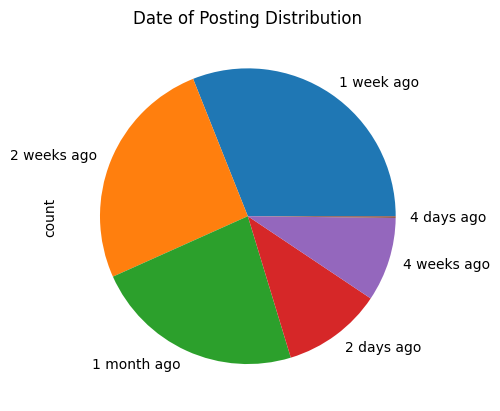

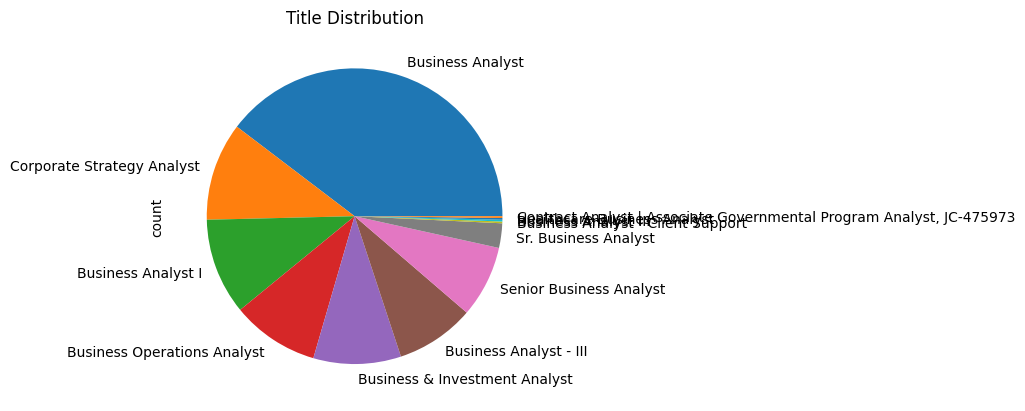

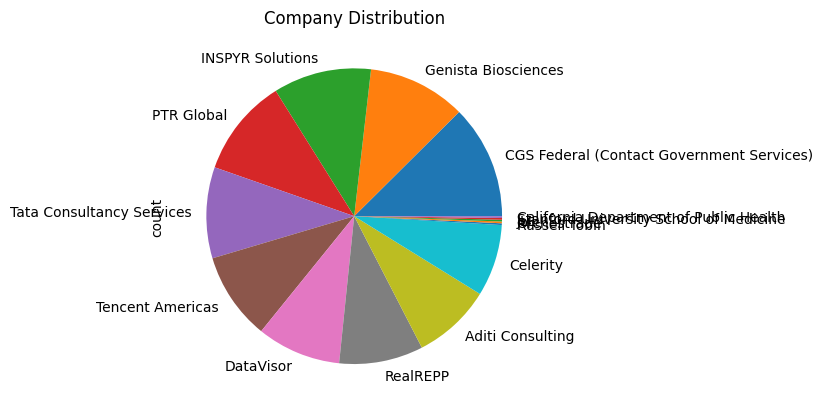

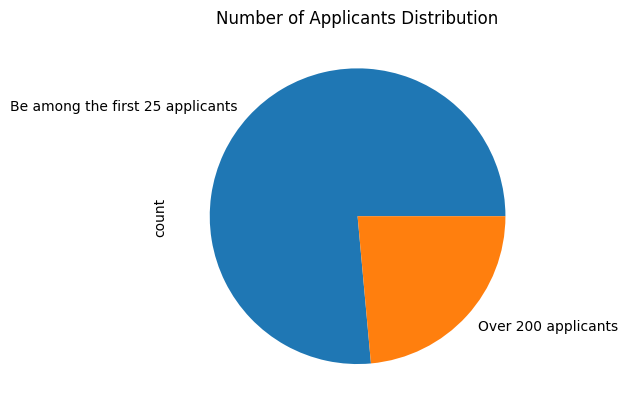

In [62]:
categorical_variables(data_analyst_jobs_df)

**Data Science Positions**

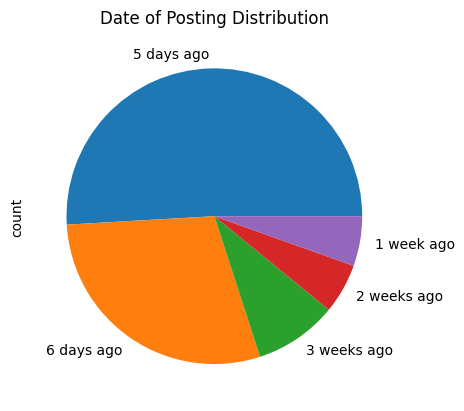

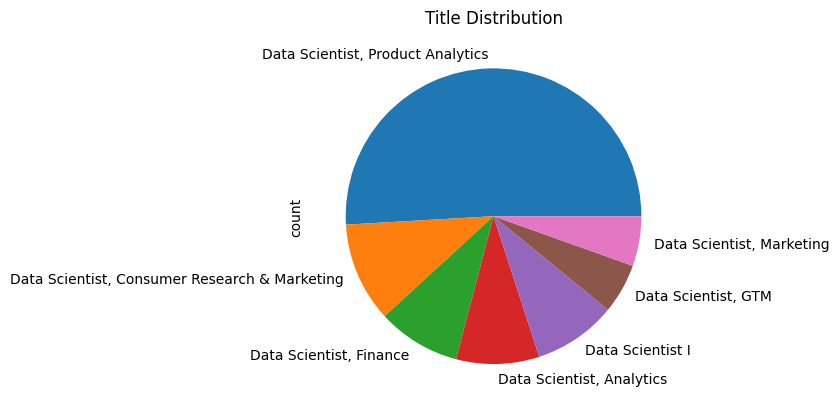

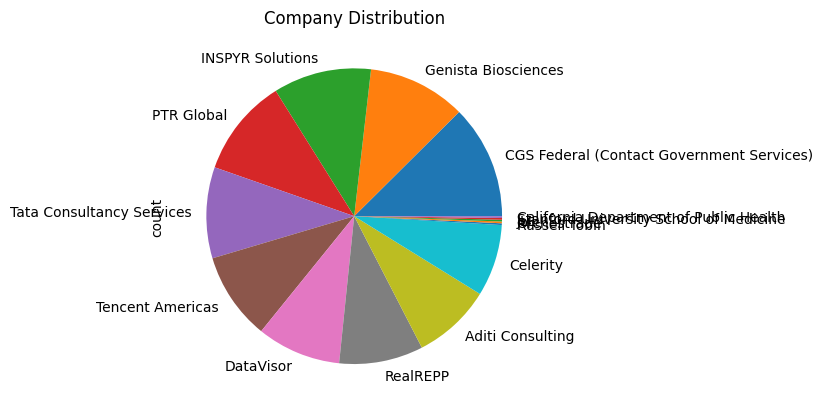

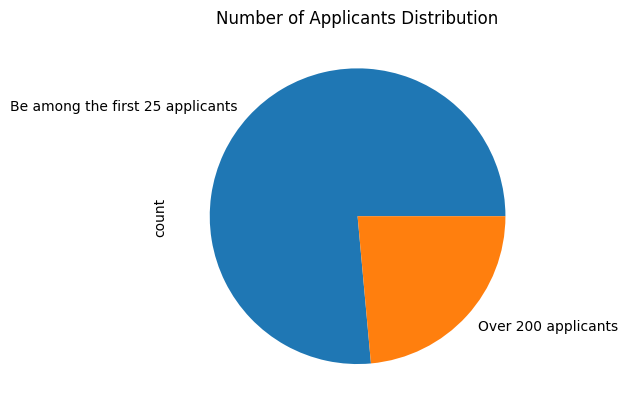

In [63]:
categorical_variables(data_science_positions)

#### Years of Experience Matches

In [69]:
#data_science_positions['job_description']

## Finding the number of job descriptions containing (' 1 year')

# Search phrase
search_phrase = '1'

# Filter the DataFrame
data_science_positions_junior = data_science_positions[data_science_positions['job_description'].str.contains(search_phrase)]